In [1]:
import os
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2

In [9]:
data_dir = r'C:\Users\haris\AI\ML\Projects\Data\Cars Dataset'

img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255,
    horizontal_flip = True,                         
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

datagen2 = ImageDataGenerator(rescale=1./255, horizontal_flip = False, validation_split=0.242)

datagen3 = ImageDataGenerator(rescale=1./255, horizontal_flip = False)

train_images = datagen.flow_from_directory(
                                          os.path.join(data_dir, 'train'),
                                          target_size = img_size,
                                          class_mode = "categorical",
                                          shuffle = True,
                                          batch_size = batch_size,
                                          subset = 'training')

valid_images = datagen2.flow_from_directory(os.path.join(data_dir, 'train'),
                                           target_size = img_size,
                                           class_mode = "categorical",
                                           shuffle = False,
                                           batch_size = batch_size,
                                           subset = 'validation')
test_images = datagen3.flow_from_directory(os.path.join(data_dir, 'test'),
                                           target_size = img_size,
                                           class_mode = "categorical",
                                           shuffle = False,
                                           batch_size = batch_size)

Found 3352 images belonging to 7 classes.
Found 807 images belonging to 7 classes.
Found 813 images belonging to 7 classes.


In [3]:
base_model = MobileNetV2(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor="val_accuracy",patience  = 5,verbose=1, restore_best_weights=True)

history = model.fit(
    train_images,
    validation_data=valid_images,
    batch_size=batch_size,
    epochs=100,
    callbacks=[early_stopping]
)


Epoch 1/100
105/105 [==============================] - 37s 302ms/step - loss: 0.9739 - accuracy: 0.6745 - val_loss: 0.4547 - val_accuracy: 0.8600
Epoch 2/100
105/105 [==============================] - 31s 293ms/step - loss: 0.5646 - accuracy: 0.8079 - val_loss: 0.4537 - val_accuracy: 0.8550
Epoch 3/100
105/105 [==============================] - 31s 295ms/step - loss: 0.4363 - accuracy: 0.8547 - val_loss: 0.2867 - val_accuracy: 0.8984
Epoch 4/100
105/105 [==============================] - 31s 294ms/step - loss: 0.4143 - accuracy: 0.8544 - val_loss: 0.2962 - val_accuracy: 0.8947
Epoch 5/100
105/105 [==============================] - 31s 294ms/step - loss: 0.3473 - accuracy: 0.8842 - val_loss: 0.2985 - val_accuracy: 0.8872
Epoch 6/100
105/105 [==============================] - 31s 295ms/step - loss: 0.3046 - accuracy: 0.8962 - val_loss: 0.2601 - val_accuracy: 0.9157
Epoch 7/100
105/105 [==============================] - 31s 294ms/step - loss: 0.2943 - accuracy: 0.9039 - val_loss: 0.2822 -

In [4]:
# Get the number of epochs from the training history
num_epochs = len(history.history['loss'])
print(num_epochs)
# Get the number of batches processed in each epoch
num_batches_per_epoch = history.params['steps']
print(num_batches_per_epoch)
# Calculate the total number of images processed
total_images_processed = num_epochs * num_batches_per_epoch * batch_size

print("Total number of images processed during training:", total_images_processed)

19
105
Total number of images processed during training: 63840


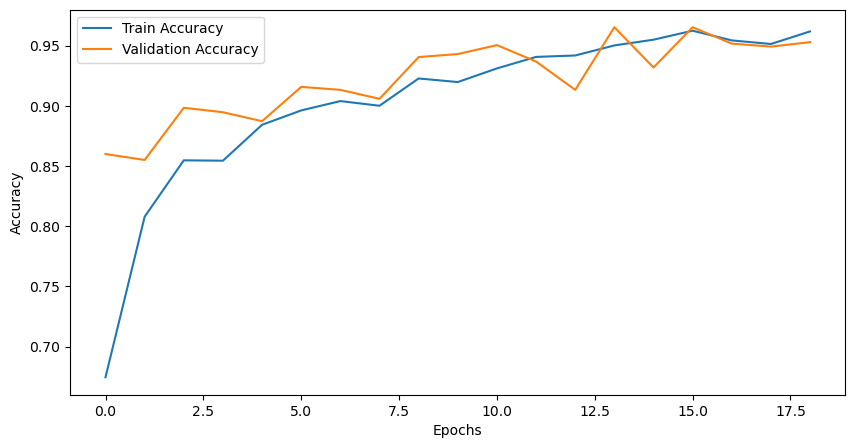

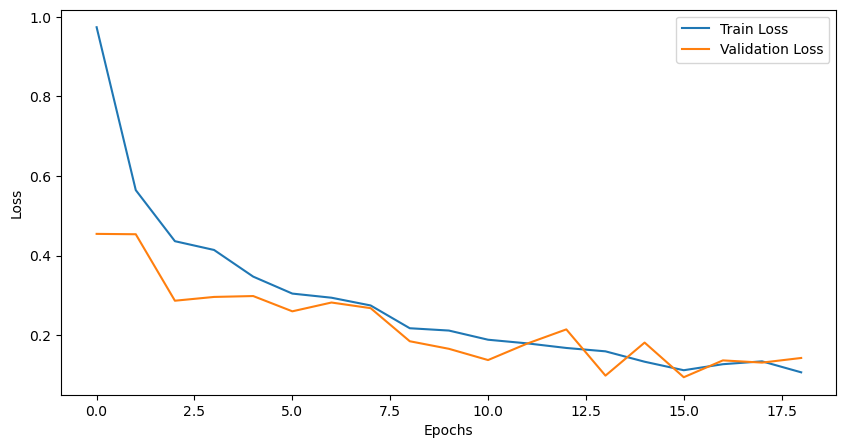

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')  
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

26/26 [==============================] - 1s 41ms/step - loss: 0.2956 - accuracy: 0.8967
Test Loss: 0.2956339418888092
Test Accuracy: 0.8966789841651917
26/26 [==============================] - 1s 41ms/step
Classification Report:
                   precision    recall  f1-score   support

            Audi       0.87      0.89      0.88       199
   Hyundai Creta       0.87      0.78      0.82        67
Mahindra Scorpio       0.97      0.92      0.95        75
     Rolls Royce       0.74      0.81      0.77        74
           Swift       0.90      0.88      0.89       102
     Tata Safari       0.95      0.90      0.92       106
   Toyota Innova       0.94      0.97      0.96       190

        accuracy                           0.90       813
       macro avg       0.89      0.88      0.88       813
    weighted avg       0.90      0.90      0.90       813



<AxesSubplot:>

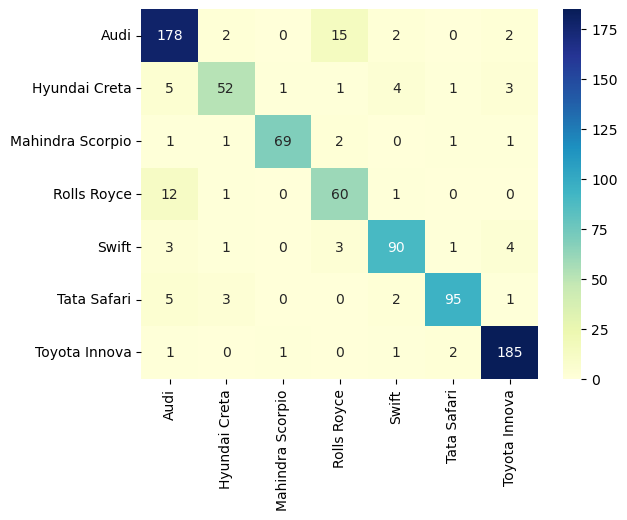

In [11]:
# Get the true classes for test data
true_classes = test_images.classes

# Get the class names for the dataset
class_names = list(test_images.class_indices.keys())

# Evaluate the model on the test data using the `evaluate` method
test_evaluation = model.evaluate(test_images)

test_loss = test_evaluation[0]
test_accuracy = test_evaluation[1]

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Generate predictions on the test data using the `predict` method
test_predictions = model.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=1)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(true_classes, test_predictions_classes)

# Print the classification report
classification_rep = classification_report(true_classes, test_predictions_classes, target_names=class_names)
print("Classification Report:\n", classification_rep)

import seaborn as sn
df_cm = pd.DataFrame(confusion_mat, index=class_names, columns=class_names)
sn.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")

In [12]:
# Create a DataFrame from the classification report
classification_dict = classification_report(true_classes, test_predictions_classes, target_names=class_names, output_dict=True)
classification_df = pd.DataFrame(classification_dict).transpose()

# Save the DataFrame as an Excel file
excel_path = os.path.join(r'C:\Users\haris\AI\ML\Projects\Data\Cars Dataset', 'classification_report.xlsx')
classification_df.to_excel(excel_path, index=True)

print(f"Classification report saved as Excel to {excel_path}")

Classification report saved as Excel to C:\Users\haris\AI\ML\Projects\Data\Cars Dataset\classification_report.xlsx


In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                                           